## ----------------------- Satisfication Index of Employee for Work Evaluation -----------------------

# Definition, Problems, Goals, Limitasi Model

------------------------------------------------------------------------------------------------------------------------------------------------------

### Definition

This Machine Learning is a model for determining the employee satisfaction index at work that can be used by companies to evaluate employee performance. So, it can be used further as a tool to select employees for promotion or attrition.

### Problems & Goals

2.1 Problems
- August 2020, Covid cases in Indonesia are still increasing (national.kompas.com). One of the effects of this covid is the reduction in the number of employees working in a company. Lots of companies lay off employees to stabilize their finances. However, when carrying out layoffs, it will be very disadvantage to the company if they fire quality employees. Therefore, this machine model will be very helpful to be used as an employee evaluation while working in a company

- According to Maier (2000: 116), the factors that affect termination of employment are:
  1. Age
  2. Length of Work
  3. Satisfaction
  4. Company Culture
  Based on the factors mentioned above, it is very important to know the Employee Job Satisfaction Index

2.2 Goals
- Knowing what variables can affect the employee job satisfaction index.
- Creating a model that can determine the employee job satisfaction index at work that can be used as a job evaluation material.

2.3 Limitation
- This model is only a tool to determine the employee satisfaction index in percentage levels, but it can be developed further to detect employee churn / no churn.
- This model can be used for various companies as a consideration in terminating or promoting employee positions.

# Import Package

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')
pd.options.display.max_columns=999

%matplotlib inline

from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler, MinMaxScaler, power_transform, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV


# Import Data

------------------------------------------------------------------------------------------------------------------------------------------------------

In [122]:
df_base = pd.read_csv('dfbase.csv', index_col=1)
dft3 = pd.read_csv('dft3.csv')

In [123]:
df_base.head()

,Unnamed: 0,age,Dept_enc,loc_enc,edu_enc,recruitmen_enc,job_level,rating,onsite,awards,certifications,salary,satisfied
empl_no,,,,,,,,,,,,,
0,0,28,0,0,1,0,5,2,0,1,0,86750,1
1,1,50,1,0,1,1,3,5,1,2,1,42419,0
2,2,43,1,0,0,0,4,1,0,2,0,65715,0
3,3,44,2,1,1,2,2,3,1,0,0,29805,1
4,4,33,0,1,0,3,2,1,0,5,0,29805,1


In [124]:
dft3.head()

,empl_no,age,Dept_enc,loc_enc,edu_enc,recruitmen_enc,job_level_1,job_level_2,job_level_3,job_level_4,job_level_5,rating_1,rating_2,rating_3,rating_4,rating_5,onsite,awards,certifications,salary,satisfied
0,0,28,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,86750,1
1,1,50,1,0,1,1,0,0,1,0,0,0,0,0,0,1,1,2,1,42419,0
2,2,43,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,2,0,65715,0
3,3,44,2,1,1,2,0,1,0,0,0,0,0,1,0,0,1,0,0,29805,1
4,4,33,0,1,0,3,0,1,0,0,0,1,0,0,0,0,0,5,0,29805,1


------------------------------------------------------------------------------------------------------------------------------------------------------

# Splitting

### Base

In [125]:
X = df_base.drop(columns='satisfied')
y = df_base.satisfied

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .2, random_state=42)

In [127]:
X_train.shape

(400, 12)

In [128]:
X_test.shape

(100, 12)

### dft3 (df_base w get_dummies)

In [129]:
X3 = dft3.drop(columns='satisfied')
y3 = dft3.satisfied

In [130]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, stratify = y3, test_size = .2, random_state=42)

In [131]:
X3_train.shape

(398, 20)

In [132]:
X3_test.shape

(100, 20)

------------------------------------------------------------------------------------------------------------------------------------------------------

# Modeling

- In using algorithms to create models, **many classification reports, confusion matrix, accuracy score and roc_auc_score will be generated**. Therefore it will be explained first here, so that it can be applied to any classification report reading, confusion matrix, and accuracy and roc_auc_score.

![ini image](https://i.ibb.co/jWc7mtX/Confusion-matrix.png)

### Classification Report Explanation
1. recall 0 (negative recall) => is the number of correct predictions in the negative class (TN) compared to the total number of actual negatives (TN + FP)
2. recall 1 (positive recall) => is the number of correct predictions in the positive class (TP) compared to the total number of actual positives (TP + FN)
3. precision 0 (negative precision) => is the number of correct predictions in the negative class (TN) compared to the total number of negative guesses (TN + FN)
4. precision 1 (positive precision) => is the number of correct predictions in the positive class (TP) compared to the total number of positive guesses (TP + FP)
5. Accuracy => all correct guesses compared to all data

- Because the dataset used has a balanced target, accuracy can also be considered as a determinant of the accuracy of the model
- The focus of the model is to obtain the highest possible positive recall and accuracy, so that false negatives can be avoided.
- The reason why False Negatives should be avoided, is because:
  - actual employees **NOT SATISFIED (0)** predictable **SATISFIED**, the company only loses in salary.
  - Whereas when the actual employee is **SATISFIED (1)** is guessed **NOT SATISFIED**, then for example the company fires him, the company will get a big loss because of losing employees who are enthusiastic at work. So that maybe the company can go bankrupt. Therefore this is what must be avoided
- This means that **modeling objectives will be sought with a high recall positive and accuracy**

### Confusion Matrix Explanation
1. TP ==> is when actual positive is guessed positive
2. FP ==> is when the actual negative is guessed positive
3. TN ==> is when the actual negative is guessed negative
4. FN ==> that is when actual positive is guessed negative


## A. Base

### 1. Base Logistic Regresion

In [133]:
modelog = LogisticRegression()
modelog.fit(X_train, y_train)

LogisticRegression()

In [134]:
y_pred = modelog.predict(X_test)

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.30      0.37        47
           1       0.54      0.74      0.62        53

    accuracy                           0.53       100
   macro avg       0.52      0.52      0.50       100
weighted avg       0.52      0.53      0.51       100



In [136]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
confuslog = pd.DataFrame(cm,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
confuslog

,Pred 1,Pred 0
Act 1,39,14
Act 0,33,14


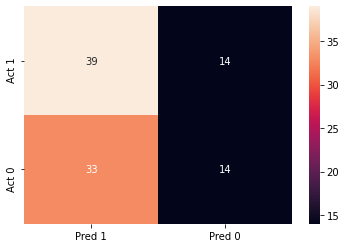

In [137]:
sns.heatmap(confuslog,annot=True)
plt.show()

In [138]:
roc_auc_score(y_test, y_pred)

0.5168606985146527

### 2. Base KNN

In [139]:
modelknn = KNeighborsClassifier(n_neighbors=5)
modelknn.fit(X_train, y_train)

KNeighborsClassifier()

In [140]:
y_predKNN = modelknn.predict(X_test)

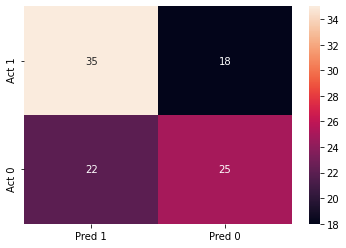

In [141]:
ck = confusion_matrix(y_test, y_predKNN, labels=[1, 0])
cknn = pd.DataFrame(ck,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(cknn,annot=True )

In [142]:
print(classification_report(y_test, y_predKNN))

              precision    recall  f1-score   support

           0       0.58      0.53      0.56        47
           1       0.61      0.66      0.64        53

    accuracy                           0.60       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.60      0.60      0.60       100



In [143]:
roc_auc_score(y_test, y_predKNN)

0.5961461260537937

### 3. Base XGBosstClassifier

In [144]:
modelxg = XGBClassifier()
modelxg.fit(X_train, y_train)

XGBClassifier()

In [145]:
y_predXGB = modelxg.predict(X_test)

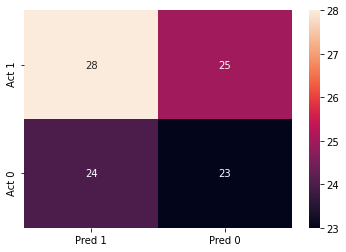

In [146]:
cxg = confusion_matrix(y_test, y_predXGB, labels=[1, 0])
cxgb = pd.DataFrame(cxg,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(cxgb,annot=True )

In [147]:
print(classification_report(y_test, y_predXGB))

              precision    recall  f1-score   support

           0       0.48      0.49      0.48        47
           1       0.54      0.53      0.53        53

    accuracy                           0.51       100
   macro avg       0.51      0.51      0.51       100
weighted avg       0.51      0.51      0.51       100



In [148]:
roc_auc_score(y_test, y_predXGB)

0.5088317944600562

## df3t (dataset with Feature Engineering & Selection)

### 1. dft3 Logistic Regresion

In [149]:
modelog3 = LogisticRegression()
modelog3.fit(X3_train, y3_train)

LogisticRegression()

In [150]:
y3_pred = modelog3.predict(X3_test)

In [151]:
cm3 = confusion_matrix(y3_test, y3_pred, labels=[1, 0])
confuslog3 = pd.DataFrame(cm3,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
confuslog3

,Pred 1,Pred 0
Act 1,28,25
Act 0,33,14


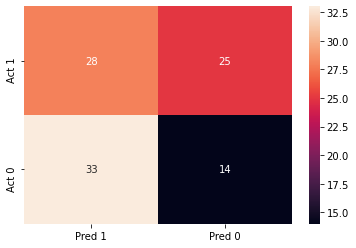

In [152]:
sns.heatmap(confuslog3,annot=True)

In [153]:
print(classification_report(y3_test, y3_pred))

              precision    recall  f1-score   support

           0       0.36      0.30      0.33        47
           1       0.46      0.53      0.49        53

    accuracy                           0.42       100
   macro avg       0.41      0.41      0.41       100
weighted avg       0.41      0.42      0.41       100



In [154]:
roc_auc_score(y3_test, y3_pred)

0.4130871136089923

### 2. dft3 KNN

In [155]:
modelknn3 = KNeighborsClassifier(n_neighbors=5)
modelknn3.fit(X3_train, y3_train)

KNeighborsClassifier()

In [156]:
y3_predKNN = modelknn3.predict(X3_test)

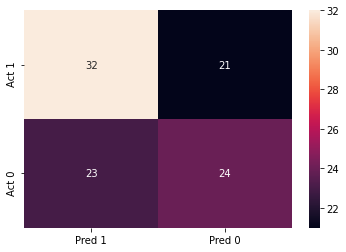

In [157]:
ck3 = confusion_matrix(y3_test, y3_predKNN, labels=[1, 0])
cknn3 = pd.DataFrame(ck3,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(cknn3,annot=True )

In [158]:
print(classification_report(y3_test, y3_predKNN))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52        47
           1       0.58      0.60      0.59        53

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100



In [159]:
roc_auc_score(y3_test, y3_predKNN)

0.5572059413890005

### 3. dft3 XGBosstClassifier

In [160]:
modelxg3 = XGBClassifier()
modelxg3.fit(X3_train, y3_train)

XGBClassifier()

In [161]:
y3_predXGB = modelxg3.predict(X3_test)

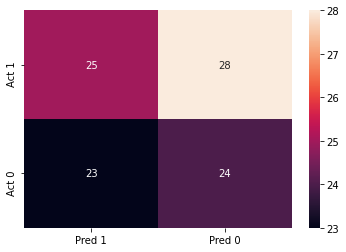

In [162]:
cxg3 = confusion_matrix(y3_test, y3_predXGB, labels=[1, 0])
cxgb3 = pd.DataFrame(cxg3,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(cxgb3,annot=True )

In [163]:
print(classification_report(y3_test, y3_predXGB))

              precision    recall  f1-score   support

           0       0.46      0.51      0.48        47
           1       0.52      0.47      0.50        53

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.49      0.49      0.49       100



In [164]:
roc_auc_score(y3_test, y3_predXGB)

0.49116820553994384

## Preprocessing (Manual Tunning & Scaling)

#### A. Manual Tuning Scalling Base With KNN

In [165]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train) 

In [166]:
X_test_scaled = scaler.fit_transform(X_test)

In [167]:
train_score = []
test_score = []

for k in range (1, 100, 2):
    knn = KNeighborsClassifier(n_neighbors= k)
    knn.fit(X_train_scaled, y_train)
#     recall_score(y_test, y_predict)
    train_score.append(knn.score(X_train_scaled, y_train))
    test_score.append(knn.score(X_test_scaled, y_test))

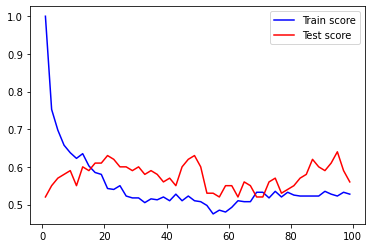

In [168]:
plt.plot(range(1, 100, 2), train_score, 'b', label='Train score')
plt.plot(range(1, 100, 2), test_score, 'r', label='Test score')
plt.legend()
plt.show()

In [169]:
print(test_score)

[0.52, 0.55, 0.57, 0.58, 0.59, 0.55, 0.6, 0.59, 0.61, 0.61, 0.63, 0.62, 0.6, 0.6, 0.59, 0.6, 0.58, 0.59, 0.58, 0.56, 0.57, 0.55, 0.6, 0.62, 0.63, 0.6, 0.53, 0.53, 0.52, 0.55, 0.55, 0.52, 0.56, 0.55, 0.52, 0.52, 0.56, 0.57, 0.53, 0.54, 0.55, 0.57, 0.58, 0.62, 0.6, 0.59, 0.61, 0.64, 0.59, 0.56]


In [170]:
np.max(test_score)

0.64

In [171]:
k = []
for i in range(1, 100, 2):
    k.append(i)
print(k)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


In [172]:
k[np.argmax(test_score)]

95

### 1. Base KNN with Scaled

In [178]:
modelknn_s = KNeighborsClassifier(n_neighbors=95)
modelknn_s.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=95)

In [179]:
y_predk_s1 = modelknn_s.predict(X_test_scaled)

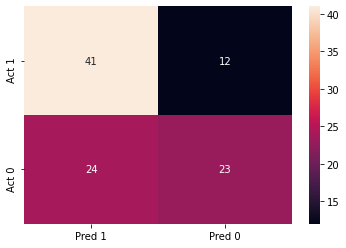

In [180]:
cks = confusion_matrix(y_test, y_predk_s1, labels=[1, 0])
cknns = pd.DataFrame(cks,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(cknns,annot=True )

In [181]:
print(classification_report(y_test, y_predk_s1))

              precision    recall  f1-score   support

           0       0.66      0.49      0.56        47
           1       0.63      0.77      0.69        53

    accuracy                           0.64       100
   macro avg       0.64      0.63      0.63       100
weighted avg       0.64      0.64      0.63       100



In [182]:
roc_auc_score(y_test, y_predk_s1)

0.6314733038940186

- Ketika rentang k (n_neighbors) dibuat pada range 1-50, diperoleh best param n_neighbors = 21

In [183]:
modelknn_s2 = KNeighborsClassifier(n_neighbors=21)
modelknn_s2.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=21)

In [184]:
y_predk_s2 = modelknn_s2.predict(X_test_scaled)

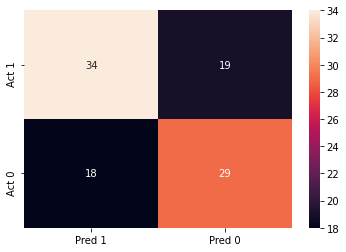

In [185]:
cks2 = confusion_matrix(y_test, y_predk_s2, labels=[1, 0])
cknns2 = pd.DataFrame(cks2,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(cknns2,annot=True )

In [186]:
print(classification_report(y_test, y_predk_s2))

              precision    recall  f1-score   support

           0       0.60      0.62      0.61        47
           1       0.65      0.64      0.65        53

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.63      0.63      0.63       100



In [187]:
roc_auc_score(y_test, y_predk_s2)

0.6292653552790044

### 2. Base scaled with XGBosstClassifier

In [188]:
modelxgs = XGBClassifier()
modelxgs.fit(X_train_scaled, y_train)

XGBClassifier()

In [189]:
y_predXGBs = modelxgs.predict(X_test_scaled)

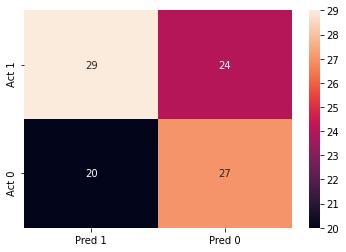

In [190]:
cxg_ = confusion_matrix(y_test, y_predXGBs, labels=[1, 0])
cxgbs = pd.DataFrame(cxg_,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(cxgbs,annot=True )

In [191]:
print(classification_report(y_test, y_predXGBs))

              precision    recall  f1-score   support

           0       0.53      0.57      0.55        47
           1       0.59      0.55      0.57        53

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100



In [192]:
roc_auc_score(y_test, y_predXGB)

0.5088317944600562

### 3. Base scaled with Logistic Regression

In [193]:
modelogs = LogisticRegression()
modelogs.fit(X_train_scaled, y_train)

LogisticRegression()

In [194]:
y_predlogs = modelogs.predict(X_test_scaled)

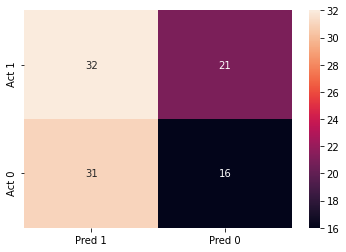

In [195]:
clog_ = confusion_matrix(y_test, y_predlogs, labels=[1, 0])
clogs = pd.DataFrame(clog_,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(clogs,annot=True )

In [196]:
print(classification_report(y_test, y_predlogs))

              precision    recall  f1-score   support

           0       0.43      0.34      0.38        47
           1       0.51      0.60      0.55        53

    accuracy                           0.48       100
   macro avg       0.47      0.47      0.47       100
weighted avg       0.47      0.48      0.47       100



In [197]:
roc_auc_score(y_test, y_predlogs)

0.47209955841027695

#### B. Manual Tuning Scalling dft3 KNN

### 1. dft3 scaled with KNN

In [198]:
scaler = StandardScaler()

X3_train_scaled = scaler.fit_transform(X3_train) 

In [199]:
X3_test_scaled = scaler.fit_transform(X3_test)

In [200]:
train_score3 = []
test_score3 = []

for k in range (1, 100, 2):
    knn3 = KNeighborsClassifier(n_neighbors= k)
    knn3.fit(X3_train_scaled, y3_train)
#     recall_score(y_test, y_predict)
    train_score3.append(knn3.score(X3_train_scaled, y3_train))
    test_score3.append(knn3.score(X3_test_scaled, y3_test))

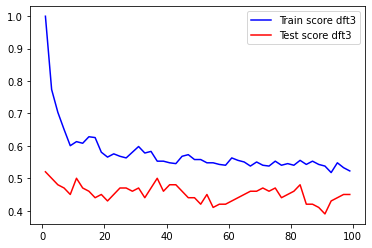

In [201]:
plt.plot(range(1, 100, 2), train_score3, 'b', label='Train score dft3')
plt.plot(range(1, 100, 2), test_score3, 'r', label='Test score dft3')
plt.legend()
plt.show()

In [202]:
print(test_score3)

[0.52, 0.5, 0.48, 0.47, 0.45, 0.5, 0.47, 0.46, 0.44, 0.45, 0.43, 0.45, 0.47, 0.47, 0.46, 0.47, 0.44, 0.47, 0.5, 0.46, 0.48, 0.48, 0.46, 0.44, 0.44, 0.42, 0.45, 0.41, 0.42, 0.42, 0.43, 0.44, 0.45, 0.46, 0.46, 0.47, 0.46, 0.47, 0.44, 0.45, 0.46, 0.48, 0.42, 0.42, 0.41, 0.39, 0.43, 0.44, 0.45, 0.45]


In [203]:
np.max(test_score3)

0.52

In [204]:
k = []
for i in range(1, 100, 2):
    k.append(i)
print(k)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]


In [205]:
k[np.argmax(test_score3)]

1

In [206]:
modelknn_s3 = KNeighborsClassifier(n_neighbors=49)
modelknn_s3.fit(X3_train_scaled, y3_train)

KNeighborsClassifier(n_neighbors=49)

In [207]:
y_predk_s3 = modelknn_s3.predict(X3_test_scaled)

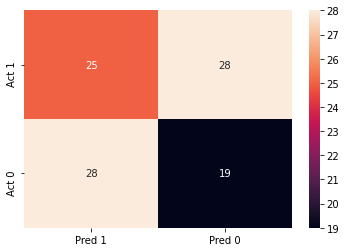

In [208]:
cks3 = confusion_matrix(y3_test, y_predk_s3, labels=[1, 0])
cknns3 = pd.DataFrame(cks3,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(cknns3,annot=True )

In [209]:
print(classification_report(y3_test, y_predk_s3))

              precision    recall  f1-score   support

           0       0.40      0.40      0.40        47
           1       0.47      0.47      0.47        53

    accuracy                           0.44       100
   macro avg       0.44      0.44      0.44       100
weighted avg       0.44      0.44      0.44       100



In [210]:
roc_auc_score(y_test, y_predk_s3)

0.37775993576876754

### 2. dft3 scaled with XGBosstClassifier

In [211]:
modelxgs = XGBClassifier()
modelxgs.fit(X_train_scaled, y_train)

XGBClassifier()

In [212]:
y_predXGBs = modelxgs.predict(X_test_scaled)

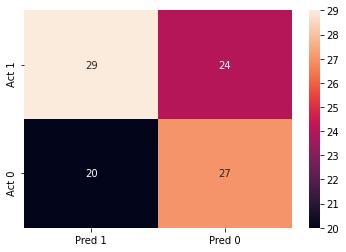

In [213]:
cxg_ = confusion_matrix(y_test, y_predXGBs, labels=[1, 0])
cxgbs = pd.DataFrame(cxg_,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(cxgbs,annot=True )

In [214]:
print(classification_report(y_test, y_predXGBs))

              precision    recall  f1-score   support

           0       0.53      0.57      0.55        47
           1       0.59      0.55      0.57        53

    accuracy                           0.56       100
   macro avg       0.56      0.56      0.56       100
weighted avg       0.56      0.56      0.56       100



In [215]:
roc_auc_score(y_test, y_predXGBs)

0.5608189482135689

### 3. dft3 scaled with XGBosstClassifier

In [216]:
modelxgs3 = XGBClassifier()
modelxgs3.fit(X3_train_scaled, y3_train)

XGBClassifier()

In [217]:
y_predXGBs3 = modelxgs3.predict(X3_test_scaled)

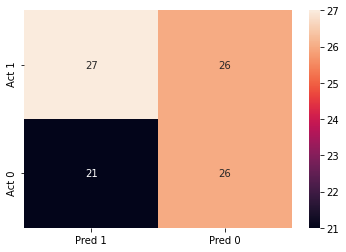

In [218]:
cxg_3 = confusion_matrix(y3_test, y_predXGBs3, labels=[1, 0])
cxgbs3 = pd.DataFrame(cxg_3,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(cxgbs3,annot=True )

In [219]:
print(classification_report(y_test, y_predXGBs3))

              precision    recall  f1-score   support

           0       0.42      0.47      0.44        47
           1       0.48      0.43      0.46        53

    accuracy                           0.45       100
   macro avg       0.45      0.45      0.45       100
weighted avg       0.45      0.45      0.45       100



In [220]:
roc_auc_score(y_test, y_predXGBs3)

0.4510236852669611

# Hyperparam

#### A. Hyperparam Base Scaled

#### 1. Hyperparameter Tuning KNN

In [148]:
modelkh = KNeighborsClassifier()

param_rf = {
    "n_neighbors" : range(50,100,1),
    "weights" : ["uniform", "distance"],
    "p" : [2, 1]
}

In [149]:
modelKRS= RandomizedSearchCV(
    estimator = modelkh, 
    param_distributions = param_rf, 
    cv = 5)

modelKGS = GridSearchCV(modelkh, param_rf, cv=5, n_jobs=-1, verbose=1)

In [150]:
modelKRS.fit(X_train_scaled, y_train)
modelKGS.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 904 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.0s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(50, 100), 'p': [2, 1],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [151]:
modelKRS.best_params_

{'weights': 'uniform', 'p': 2, 'n_neighbors': 70}

In [152]:
modelKGS.best_params_

{'n_neighbors': 78, 'p': 1, 'weights': 'uniform'}

In [153]:
y_pred_KRS = modelKRS.predict(X_test_scaled)
y_pred_KGS = modelKGS.predict(X_test_scaled)

In [154]:
print(classification_report(y_test, y_pred_KRS))

              precision    recall  f1-score   support

           0       0.50      0.43      0.46        47
           1       0.55      0.62      0.58        53

    accuracy                           0.53       100
   macro avg       0.53      0.52      0.52       100
weighted avg       0.53      0.53      0.53       100



In [155]:
print(classification_report(y_test, y_pred_KGS))

              precision    recall  f1-score   support

           0       0.51      0.40      0.45        47
           1       0.56      0.66      0.60        53

    accuracy                           0.54       100
   macro avg       0.53      0.53      0.53       100
weighted avg       0.54      0.54      0.53       100



#### 2. Hyperparameter Tuning Logistic Regression

In [156]:
modelogh = LogisticRegression()
paramlog = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter':[1, 10, 100, 1000, 10000],
    'multi_class':['auto', 'ovr']
}

In [157]:
modelLRS = RandomizedSearchCV(
    estimator = modelogh, 
    param_distributions = paramlog, cv = 5)

modelLGS = GridSearchCV(modelogh, paramlog, cv=5, n_jobs=-1, verbose=1)

In [158]:
modelLRS.fit(X_train_scaled, y_train)
modelLGS.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    1.1s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [1, 10, 100, 1000, 10000],
                         'multi_class': ['auto', 'ovr'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=1)

In [159]:
modelLRS.best_params_
# LogisticRegression('solver': 'saga', 'penalty': 'l2')

{'solver': 'liblinear',
 'penalty': 'l1',
 'multi_class': 'ovr',
 'max_iter': 1000}

In [160]:
modelLGS.best_params_

{'max_iter': 1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'saga'}

In [161]:
y_pred_RS_L = modelLRS.predict(X_test_scaled)
y_pred_GS_L = modelLGS.predict(X_test_scaled)
# y_rf = modelRF.predict(X_test)

In [162]:
print(classification_report(y_test, y_pred_RS_L))

              precision    recall  f1-score   support

           0       0.44      0.34      0.39        47
           1       0.52      0.62      0.56        53

    accuracy                           0.49       100
   macro avg       0.48      0.48      0.47       100
weighted avg       0.48      0.49      0.48       100



In [163]:
print(classification_report(y_test, y_pred_GS_L))

              precision    recall  f1-score   support

           0       0.56      0.43      0.48        47
           1       0.58      0.70      0.63        53

    accuracy                           0.57       100
   macro avg       0.57      0.56      0.56       100
weighted avg       0.57      0.57      0.56       100



#### 3. Hyperparameter Tuning XGBClassifier

In [167]:
modelxgh = XGBClassifier()
paramxg = {
    'max_depth':np.random.randint(1,10,10),
    'learning_rate': np.logspace(-3,0,15),
    'n_estimators':np.random.randint(100,200,10),
    'gamma':np.random.randint(1,10,10)
}

In [168]:
modelXRS = RandomizedSearchCV(
    estimator = modelxgh, 
    param_distributions = paramxg, cv = 5)

modelXGS = GridSearchCV(modelxgh, paramxg, cv=5, n_jobs=-1, verbose=1)

In [169]:
modelXRS.fit(X_train_scaled, y_train)
modelXGS.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 15000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1464 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 2864 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 4664 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6864 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 9464 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 12464 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 15864 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 19664 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 23864 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 28464 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 33464 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 38864 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 44664 tas

GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'gamma': array([4, 7, 9, 2, 2, 7, 5, 8, 3, 7]),
                         'learning_rate': array([0.001     , 0.00163789, 0.0026827 , 0.00439397, 0.00719686,
       0.01178769, 0.01930698, 0.03162278, 0.05179475, 0.08483429,
       0.13894955, 0.22758459, 0.37275937, 0.61054023, 1.        ]),
                         'max_depth': array([6, 1, 6, 9, 2, 1, 1, 3, 5, 2]),
                         'n_estimators': array([157, 113, 103, 198, 135, 164, 104, 131, 197, 191])},
             verbose=1)

In [170]:
modelXRS.best_params_
# LogisticRegression('solver': 'saga', 'penalty': 'l2')

{'n_estimators': 197,
 'max_depth': 6,
 'learning_rate': 0.3727593720314938,
 'gamma': 5}

In [171]:
modelXGS.best_params_

{'gamma': 2,
 'learning_rate': 0.0071968567300115215,
 'max_depth': 3,
 'n_estimators': 157}

In [172]:
y_pred_RS_X = modelXRS.predict(X_test_scaled)
y_pred_GS_X = modelXGS.predict(X_test_scaled)
# y_rf = modelRF.predict(X_test)

In [173]:
print(classification_report(y_test, y_pred_RS_X))

              precision    recall  f1-score   support

           0       0.47      0.47      0.47        47
           1       0.53      0.53      0.53        53

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.50      0.50      0.50       100



In [174]:
print(classification_report(y_test, y_pred_GS_X))

              precision    recall  f1-score   support

           0       0.56      0.57      0.57        47
           1       0.62      0.60      0.61        53

    accuracy                           0.59       100
   macro avg       0.59      0.59      0.59       100
weighted avg       0.59      0.59      0.59       100



#### B. Hyperparam df3t Scaled

#### 1. Hyperparameter Tuning KNN

In [175]:
modelkh3 = KNeighborsClassifier()

param_rf3 = {
    "n_neighbors" : np.random.randint(100,200,10),
    "weights" : ["uniform", "distance"],
    "p" : np.random.randint(1,10,10)
}

In [176]:
modelKRSh3= RandomizedSearchCV(
    estimator = modelkh3, 
    param_distributions = param_rf3, 
    cv = 5)

modelKGSh3 = GridSearchCV(modelkh3, param_rf3, cv=5, n_jobs=-1, verbose=1)

In [177]:
modelKRSh3.fit(X3_train_scaled, y_train)
modelKGSh3.fit(X3_train_scaled, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 985 out of 1000 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([196, 193, 103, 100, 172, 163, 168, 146, 117, 125]),
                         'p': array([5, 2, 7, 5, 9, 8, 2, 3, 2, 2]),
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [178]:
modelKRSh3.best_params_

{'weights': 'uniform', 'p': 7, 'n_neighbors': 125}

In [179]:
modelKGSh3.best_params_

{'n_neighbors': 193, 'p': 8, 'weights': 'uniform'}

In [180]:
y_pred_KRSh3 = modelKRSh3.predict(X3_test_scaled)
y_pred_KGSh3 = modelKGSh3.predict(X3_test_scaled)

In [181]:
print(classification_report(y_test, y_pred_KRSh3))

              precision    recall  f1-score   support

           0       0.42      0.23      0.30        47
           1       0.51      0.72      0.60        53

    accuracy                           0.49       100
   macro avg       0.47      0.48      0.45       100
weighted avg       0.47      0.49      0.46       100



In [225]:
print(classification_report(y_test, y_pred_KGSh3))

              precision    recall  f1-score   support

           0       0.56      0.21      0.31        47
           1       0.55      0.85      0.67        53

    accuracy                           0.55       100
   macro avg       0.55      0.53      0.49       100
weighted avg       0.55      0.55      0.50       100



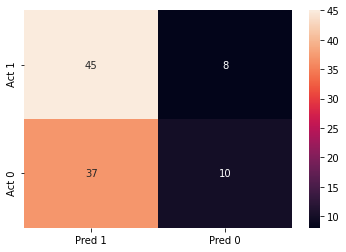

In [201]:
ckgsh_ = confusion_matrix(y3_test, y_pred_KGSh3, labels=[1, 0])
ckgsh3 = pd.DataFrame(ckgsh_,
                 columns=['Pred 1', 'Pred 0'],
                 index=['Act 1', 'Act 0'])
sns.heatmap(ckgsh3,annot=True )

#### 2. Hyperparameter Tuning Logistic Regression

In [183]:
modelogh3 = LogisticRegression()
paramlogh3 = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter':[1, 10, 100, 1000, 10000],
    'multi_class':['auto', 'ovr']
}

In [185]:
modelLRSh3 = RandomizedSearchCV(
    estimator = modelogh3, 
    param_distributions = paramlogh3, cv = 5)

modelLGSh3 = GridSearchCV(modelogh3, paramlogh3, cv=5, n_jobs=-1, verbose=1)

In [186]:
modelLRSh3.fit(X3_train_scaled, y_train)
modelLGSh3.fit(X3_train_scaled, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    1.2s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [1, 10, 100, 1000, 10000],
                         'multi_class': ['auto', 'ovr'],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=1)

In [187]:
modelLRSh3.best_params_
# LogisticRegression('solver': 'saga', 'penalty': 'l2')

{'solver': 'saga', 'penalty': 'l1', 'multi_class': 'ovr', 'max_iter': 100}

In [188]:
modelLGSh3.best_params_

{'max_iter': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'sag'}

In [189]:
y_pred_RS_Lh3 = modelLRSh3.predict(X3_test_scaled)
y_pred_GS_Lh3 = modelLGSh3.predict(X3_test_scaled)
# y_rf = modelRF.predict(X_test)

In [190]:
print(classification_report(y_test, y_pred_RS_Lh3))

              precision    recall  f1-score   support

           0       0.44      0.34      0.39        47
           1       0.52      0.62      0.56        53

    accuracy                           0.49       100
   macro avg       0.48      0.48      0.47       100
weighted avg       0.48      0.49      0.48       100



In [191]:
print(classification_report(y_test, y_pred_GS_Lh3))

              precision    recall  f1-score   support

           0       0.46      0.45      0.45        47
           1       0.52      0.53      0.52        53

    accuracy                           0.49       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.49      0.49      0.49       100



#### 3. Hyperparameter Tuning XGBClassifier

In [192]:
modelxgh3 = XGBClassifier()
paramxgh3 = {
    'max_depth':np.random.randint(1,10,10),
    'learning_rate': np.logspace(-3,0,15),
    'n_estimators':np.random.randint(100,200,10),
    'gamma':np.random.randint(1,10,10)
}

In [193]:
modelXRSh3 = RandomizedSearchCV(
    estimator = modelxgh3, 
    param_distributions = paramxgh3, cv = 5)

modelXGSh3 = GridSearchCV(modelxgh3, paramxgh3, cv=5, n_jobs=-1, verbose=1)

In [194]:
modelXRSh3.fit(X3_train_scaled, y_train)
modelXGSh3.fit(X3_train_scaled, y_train)

Fitting 5 folds for each of 15000 candidates, totalling 75000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 1464 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 2364 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4764 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6264 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 7964 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 9864 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 11964 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 14264 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 16764 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 19464 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 22364 tasks  

GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'gamma': array([6, 5, 2, 7, 3, 5, 8, 4, 2, 9]),
                         'learning_rate': array([0.001     , 0.00163789, 0.0026827 , 0.00439397, 0.00719686,
       0.01178769, 0.01930698, 0.03162278, 0.05179475, 0.08483429,
       0.13894955, 0.22758459, 0.37275937, 0.61054023, 1.        ]),
                         'max_depth': array([7, 4, 9, 3, 8, 8, 7, 3, 6, 6]),
                         'n_estimators': array([194, 137, 161, 190, 143, 116, 190, 125, 160, 170])},
             verbose=1)

In [195]:
modelXRSh3.best_params_
# LogisticRegression('solver': 'saga', 'penalty': 'l2')

{'n_estimators': 194,
 'max_depth': 7,
 'learning_rate': 0.08483428982440717,
 'gamma': 9}

In [196]:
modelXGSh3.best_params_

{'gamma': 6,
 'learning_rate': 0.0026826957952797246,
 'max_depth': 7,
 'n_estimators': 194}

In [197]:
y_pred_RS_Xh3 = modelXRSh3.predict(X3_test_scaled)
y_pred_GS_Xh3 = modelXGSh3.predict(X3_test_scaled)
# y_rf = modelRF.predict(X_test)

In [198]:
print(classification_report(y_test, y_pred_RS_Xh3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.53      1.00      0.69        53

    accuracy                           0.53       100
   macro avg       0.27      0.50      0.35       100
weighted avg       0.28      0.53      0.37       100



In [199]:
print(classification_report(y_test, y_pred_GS_Xh3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        47
           1       0.53      1.00      0.69        53

    accuracy                           0.53       100
   macro avg       0.27      0.50      0.35       100
weighted avg       0.28      0.53      0.37       100



# Try to Change Model

In [202]:
modelDT = DecisionTreeClassifier()
modelRF = RandomForestClassifier()

In [209]:
modelRF.fit(X3_train_scaled, y_train)

RandomForestClassifier()

In [210]:
modelDT.fit(X3_train_scaled, y_train)

DecisionTreeClassifier()

In [211]:
y_rf = modelRF.predict(X3_test_scaled)

In [212]:
y_dt = modelDT.predict(X3_test_scaled)

In [213]:
print(classification_report(y_test, y_rf))

              precision    recall  f1-score   support

           0       0.47      0.47      0.47        47
           1       0.53      0.53      0.53        53

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.50      0.50      0.50       100



In [214]:
print(classification_report(y_test, y_dt))

              precision    recall  f1-score   support

           0       0.50      0.49      0.49        47
           1       0.56      0.57      0.56        53

    accuracy                           0.53       100
   macro avg       0.53      0.53      0.53       100
weighted avg       0.53      0.53      0.53       100



# Model Selection & Comparison

### Comparison of Classification Report Top 4 Models with Recall 1 and High Accuracy

In [228]:
print(classification_report(y_test, y_predk_s1)) #KNN Base with scaled, n_neighbors=95
print(classification_report(y_test, y_predk_s2)) #KNN Base with scaled, n_neighbors=21
print(classification_report(y3_test, y_predk_s3)) #KNN dft3 with scaled, n_neighbors=49
print(classification_report(y_test, y_pred_KGSh3)) #KNN Base with hyperparam GridsearchCV {'n_neighbors': 193, 'p': 8, 'weights': 'uniform'}

              precision    recall  f1-score   support

           0       0.66      0.49      0.56        47
           1       0.63      0.77      0.69        53

    accuracy                           0.64       100
   macro avg       0.64      0.63      0.63       100
weighted avg       0.64      0.64      0.63       100

              precision    recall  f1-score   support

           0       0.60      0.62      0.61        47
           1       0.65      0.64      0.65        53

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.63      0.63      0.63       100

              precision    recall  f1-score   support

           0       0.58      0.38      0.46        47
           1       0.58      0.75      0.66        53

    accuracy                           0.58       100
   macro avg       0.58      0.57      0.56       100
weighted avg       0.58      0.58      0.56       100

              preci

#### The selected model is KNN__*Base with Scaled n_neighbors = 95*__

# Export & Try Model

In [224]:
modelbest = KNeighborsClassifier(n_neighbors=95)

In [225]:
modelbest.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=95)

In [226]:
y_pred = modelbest.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.49      0.56        47
           1       0.63      0.77      0.69        53

    accuracy                           0.64       100
   macro avg       0.64      0.63      0.63       100
weighted avg       0.64      0.64      0.63       100



In [227]:
joblib.dump(modelknn_s,'knns95')

['knns95']

In [228]:
bestmodel = joblib.load('knns95')

In [231]:
X_test_scaled[1]

array([ 1.08640024, -1.4364657 , -0.08515994,  0.94169658,  0.85096294,
       -0.3998006 , -0.85698896,  1.42884613,  0.88640526, -1.4665096 ,
       -1.22474487, -0.9947558 ])

In [246]:
sample = pd.DataFrame([X_test_scaled[10]])
sample

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.51891,1.02911,0.624506,0.941697,-1.175139,-1.351707,0.514193,0.728431,0.886405,-0.473388,0.816497,0.461488


In [269]:
predict_ = bestmodel.predict([X_test_scaled[10]])

In [273]:
predict_

array([1], dtype=int64)

In [271]:
hasil_predict = print(predict_[0])
hasil_predict

1


In [272]:
y_test.iloc[5]

1

# Conclusion
- This model can be used to classify / determine the employee job satisfaction index with an accuracy score of 63%
- The variables that determine the determination of the job satisfaction index are salary, job_ level, certification, rank, and education

# Suggestion
- We recommend adding data to optimize roc_auc_score, accuracy_score for this model. 

# Referensi

1. https://www.pikiran-rakyat.com/jawa-barat/pr-01660768/gelombang-phk-masih-terus-terjadi-di-tengah-pandemi-virus-corona
2. https://nasional.kompas.com/read/2020/08/10/15004201/update-bertambah-1687-total-ada-127083-kasus-covid-19-di-indonesia?page=all
3. https://www.lexology.com/library/detail.aspx?g=5f3119f9-84ea-4cc6-a769-dc76e9c65630
4. Maier. 2000. Manajemen Personalia & Faktor-faktor yang Mempengaruhi Pemutusan Hubungan Kerja. BPFE, Yogyakarta
5. https://blog.recruitee.com/recruitment-methods/
6. https://www.talentlyft.com/en/resources/what-is-employee-referral#:~:text=Employee%20referral%20is%20an%20internal,candidates%20from%20their%20existing%20networks.
7. https://www.quora.com/What-is-a-walk-in-interview

------------------------------------------------------------------------------------------------------------------------------------------------------